<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/keras_dis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/disseration/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/disseration


Import modules

In [2]:
%tensorflow_version 2.x
!pip install pynndescent

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import string

import pynndescent
import numpy as np
import h5py
from urllib.request import urlretrieve
import os
import seaborn as sns

Import Mnist dataset

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split test set into calibration set
x_cal = x_test[0:750]
y_cal = y_test[0:750]
x_test = x_test[750:10000]
y_test = y_test[750:10000]


# x_cal = x_test[9250:10000]
# y_cal = y_test[9250:10000]
# x_test = x_test[0:9250]
# y_test = y_test[0:9250]

Initialize CNN model

In [137]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding="same", activation="relu", input_shape=x_train.shape[1:]),
        layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding="valid", activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding="valid", activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation=tf.nn.softmax),
    ]
)

batch_size = 500
epochs = 8

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        4160      
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 128)         295040    
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 128)         409728    
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 710,218
Trainable params: 710,218
Non-tr

Train model


In [138]:
# try:
#   keras.backend.set_learning_phase(False)
#   model = load_model('deepKNN_model.h5')
#   print("loaded model successfully")
# except: 
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1) #0.1
# model.save('deepKNN_model.h5')  # creates a HDF5 file
print("saved model successfully")

Epoch 1/8
108/108 [==============================] - 3s 13ms/step - loss: 0.4584 - accuracy: 0.8629 - val_loss: 0.0889 - val_accuracy: 0.9743
Epoch 2/8
108/108 [==============================] - 1s 12ms/step - loss: 0.1268 - accuracy: 0.9636 - val_loss: 0.0630 - val_accuracy: 0.9807
Epoch 3/8
108/108 [==============================] - 1s 12ms/step - loss: 0.0854 - accuracy: 0.9742 - val_loss: 0.0485 - val_accuracy: 0.9845
Epoch 4/8
108/108 [==============================] - 1s 12ms/step - loss: 0.0658 - accuracy: 0.9813 - val_loss: 0.0390 - val_accuracy: 0.9892
Epoch 5/8
108/108 [==============================] - 1s 12ms/step - loss: 0.0549 - accuracy: 0.9834 - val_loss: 0.0358 - val_accuracy: 0.9912
Epoch 6/8
108/108 [==============================] - 1s 12ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0405 - val_accuracy: 0.9890
Epoch 7/8
108/108 [==============================] - 1s 12ms/step - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.0418 - val_accuracy: 0.9895
Epoch 

Evaluate model

In [140]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.028640955686569214
Test accuracy: 0.9911351203918457


Plot image

In [131]:
def plot_image(img):
  plt.imshow(img.reshape((28, 28)), cmap='gray', interpolation='none')
  cbar = plt.colorbar()
  cbar.set_label('Pixel Intensity')
  plt.show()

Generate Adversarial Examples

In [132]:
# import the necessary packages
from tensorflow.keras.losses import MSE
import tensorflow as tf
def generate_image_adversary(model, image, label, eps):
  # cast the image
  image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)
  # record our gradients
  with tf.GradientTape() as tape:
    # explicitly indicate that our image should be tacked for
    # gradient updates
    tape.watch(image)
    # use our model to make predictions on the input image and
    # then compute the loss
    pred = model(image)
    loss = MSE(label, pred)

    # calculate the gradients of loss with respect to the image, then
    # compute the sign of the gradient
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    # construct the image adversary
    adversary = (image + (signedGrad * eps)).numpy()
    # return the image adversary to the calling function
    return adversary.reshape(28, 28, 1)

In [133]:
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]
adversaries = {}

def load_adversaries(adversaries):  
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    path = 'adv_datasets/adversaries' + eps_str + '.npy'
    adversaries[eps] = np.load(path)

def save_adversaries():
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    filename = 'adv_datasets/adversaries' + eps_str + '.npy'
    np.save(filename, adversaries[eps])

try:
  epsilons.insert(0, 0.0)
  load_adversaries(adversaries)
  print('loaded adversaries dataset successfully')
except:
  for eps in epsilons:
    adv = []
    for i in range(x_test.shape[0]):
      adv.append(generate_image_adversary(model, x_test[i], y_test[i], eps))
    adversaries[eps] = np.array(adv)
  epsilons.insert(0, 0.0)
  adversaries[0.0] = x_test
  save_adversaries()
  print('saved adversaries dataset successfully')

loaded adversaries dataset successfully


Test model on adversarial attacks

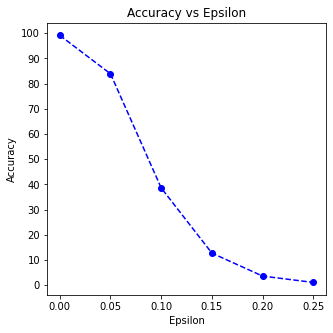

In [135]:
accuracies_plot = []
for eps in epsilons:
  adversary_score = model.evaluate(adversaries[eps], y_test, verbose=0)
  accuracies_plot.append(adversary_score[1] * 100)
  
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_plot, linestyle='--', marker='o', color='b')
plt.yticks(np.arange(0, 101, step=10))
plt.xticks(np.arange(0, .26, step=0.05))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilon")
plt.show()

Plot some adversarial examples

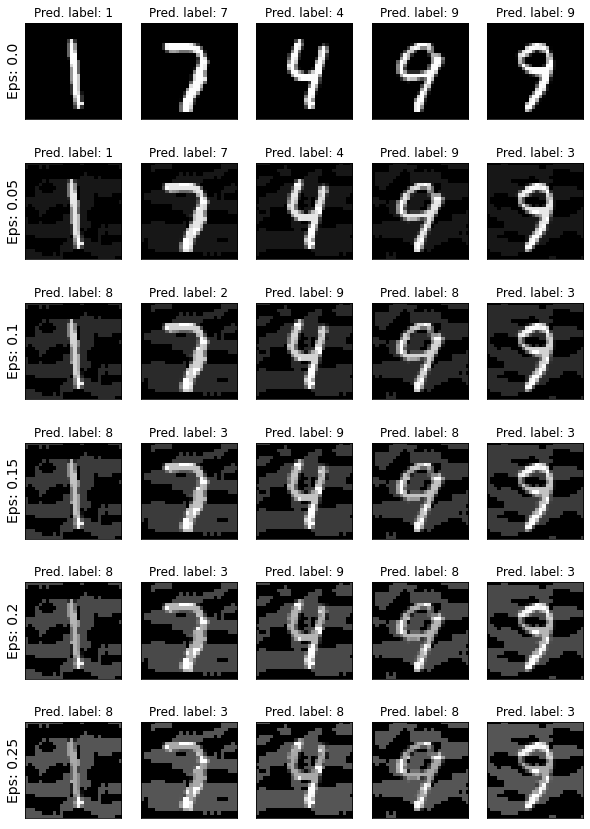

In [136]:
cnt = 0
plt.figure(figsize=(10,15))
for eps in epsilons:
  adv_img = adversaries[eps][5:10]
  true_label = y_test[5:10]

  adv_results = model.predict(adversaries[eps][5:10])
  predicted_labels = []
  for result in adv_results:
    predicted_labels.append(np.argmax(result))

  for i in range(5):
      cnt += 1
      plt.subplot(len(epsilons), 5, cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if i == 0:
        plt.ylabel("Eps: {}".format(eps), fontsize=14)
      plt.title("Pred. label: {}".format(predicted_labels[i]))
      plt.imshow(np.squeeze(adv_img[i]), cmap="gray")
# plt.tight_layout()
plt.show()

KNN for patterns

In [12]:
# # reformat training data
# x_train_knn = np.squeeze(x_train, -1)
# x_train_knn = x_train_knn.reshape((60000, 784))

# # index training data
# index = pynndescent.NNDescent(x_train_knn)

# # prepare for faster query
# index.prepare()

# # reformat test data
# x_test_knn = np.squeeze(x_test, -1)
# x_test_knn = x_test_knn.reshape((10000, 784))

# # find neighbors for test data
# neighbors = index.query(x_test_knn)

# ## create gold standard from KDTree ###
# from sklearn.neighbors import KDTree
# tree_index = KDTree(x_train)

# tree_neighbors = tree_index.query(x_test, k=10)

# def accuracy_per_query_point(approx_neighbors, true_neighbors):
#     approx_indices = approx_neighbors[0]
#     result = np.zeros(approx_indices.shape[0])
#     for i in range(approx_indices.shape[0]):
#         n_correct = np.intersect1d(approx_indices[i], true_neighbors[i]).shape[0]
#         result[i] = n_correct / true_neighbors.shape[1]
#     return result

# tree_N = np.load('test_true_neighbors.npy')

# accuracy_stats = accuracy_per_query_point(neighbors, tree_N)
# sns.set(rc={"figure.figsize":(10,6)})

# sns.distplot(accuracy_stats, kde=False)
# plt.title("Distribution of accuracy per query point")
# plt.xlabel("Accuracy")
# print(f"Average accuracy of {np.mean(accuracy_stats)}")

KNN for first CNN layer

Get activations on each layer

In [13]:
def reshaped_layer(model, x):
    #function to get the layer wise output representation of the model for data x
    layer_output = []

    for i in [0,1,2,5]:
        layer = model.layers[i]
        l_op = K.function([model.layers[0].input], [layer.output])([x])[0]
        layer_output.append(l_op)

    reshaped_output_layer = []
    
    for output in layer_output[0:3]:
        reshaped_output_layer.append(output.reshape(output.shape[0], output.shape[1]*output.shape[2]*output.shape[3]))
        
    reshaped_output_layer.append(layer_output[3])
    
    for layer in reshaped_output_layer:
        assert layer.dtype == np.float32
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)
    return(reshaped_output_layer)

Index trainingset knn

In [14]:
%%time
# With GPU
# CPU times: user 12min 3s, sys: 5.39 s, total: 12min 8s
# Wall time: 3min 46s
def index_layer(layer):
  layer_act = activations_train[layer]
  index_act = pynndescent.NNDescent(layer_act) # index training data
  index_act.prepare()# prepare for faster query
  return index_act

activations_train = reshaped_layer(model, x_train)

index_act = {}
for layer in range (0,4):
  index_act[layer] = index_layer(layer)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 11min 53s, sys: 5.4 s, total: 11min 58s
Wall time: 3min 38s


Find Neigbours

In [112]:
def find_neighbours(activations, index, layer, knn_eps):
  act = activations[layer]
  neighbors = index.query(act, k=15, epsilon=knn_eps)
  return neighbors

def correct_neighbours_count(neihgbours):
  correct_neighbours = [0] * 16
  for i in range(0, neihgbours[0].shape[0]):
    correct = 0
    for j in neihgbours[0][i]:
      if (np.argmax(y_train[j]) == (np.argmax(y_test[i]))):
        correct += 1
    correct_neighbours[correct] += 1
  return correct_neighbours

def compare_neigbours(neighbours, layer, eps):
  x_ax = np.arange(len(neighbours[layer][0.0]))
  plt.bar(x_ax-0.2, neighbours[layer][0.0], 0.4, label = 'Epsilon: 0.0')
  plt.bar(x_ax+0.2, neighbours[layer][eps], 0.4, label = 'Epsilon: ' + str(eps))

  plt.xlabel("Neigbours")
  plt.ylabel("Number of correct neigbours")
  plt.title("Number of correct neigbours on layer number: " + str(layer+1))
  plt.legend()

  plt.xticks(x_ax);
  plt.show() 

In [16]:
activations = {}
for eps in epsilons:
  activations[eps] = reshaped_layer(model, adversaries[eps])

In [17]:
%%time
# With GPU
# 7 min
neighbors = {}
for layer in range (0,4):
  neighbors[layer] = {} # useless?
  for eps in epsilons:
    neighbors[layer][eps] = find_neighbours(activations[eps], index_act[layer], layer, 0.1)

CPU times: user 2min 33s, sys: 876 ms, total: 2min 34s
Wall time: 2min 32s


In [34]:
correct_neighbours = {}
for layer in range (0,4):
  correct_neighbours[layer] = {}
  for eps in epsilons:
    correct_neighbours[layer][eps] = correct_neighbours_count(neighbors[layer][eps])

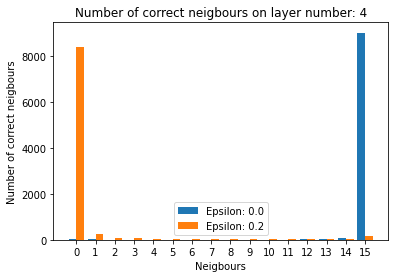

In [111]:
compare_neigbours(correct_neighbours, 3, 0.2)

Calibration set

In [36]:
activations_calib = reshaped_layer(model, x_cal)
neigbours_calib = {}
for layer in range (0,4):
  neigbours_calib[layer] = find_neighbours(activations_calib, index_act[layer], layer, 0.1)[0]

In [37]:
def nonconformity_count(neihgbours_arr, y_true, y_predicted):
  nonconformity = []
  for i in range(0, neihgbours_arr.shape[0]):
    incorrect = 0
    for j in neihgbours_arr[i]:
      if (np.argmax(y_true[j]) != (np.argmax(y_predicted[i]))):
        incorrect += 1
    nonconformity.append(incorrect)
  return np.array(nonconformity)

nonconformity = np.zeros(neigbours_calib[0].shape[0])

for layer in range (0,4):
  nonconformity += nonconformity_count(neigbours_calib[layer], y_train, y_cal)

In [89]:
nonconformity_test = np.zeros(9250)

for layer in range (0,4):
  nonconformity_test += nonconformity_count(neighbors[layer][0.15][0], y_train, y_test)

counter_arr = []
for i in range(0,9250):
  counter_non = 0
  for noncon in nonconformity:
    if noncon >= nonconformity_test[i]:
      counter_non += 1
  counter_non = counter_non / nonconformity.shape[0]
  counter_arr.append(counter_non)

In [90]:
nonconformity_test2 = np.zeros(9250)

for layer in range (0,4):
  nonconformity_test2 += nonconformity_count(neighbors[layer][0.0][0], y_train, y_test)

counter_arr2 = []
for i in range(0,9250):
  counter_non2 = 0
  for noncon in nonconformity:
    if noncon >= nonconformity_test2[i]:
      counter_non2 += 1
  counter_non2 = counter_non2 / nonconformity.shape[0]
  counter_arr2.append(counter_non2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


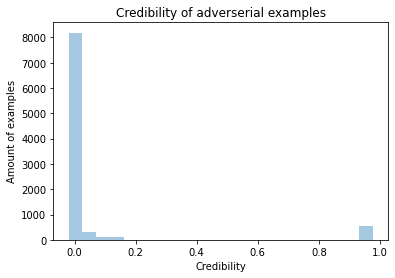

In [123]:
ax = sns.distplot(counter_arr, bins="doane",kde=False,hist_kws={"align" : "left"}).set_title("Credibility of adverserial examples")
plt.xlabel("Credibility")
plt.ylabel("Amount of examples")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


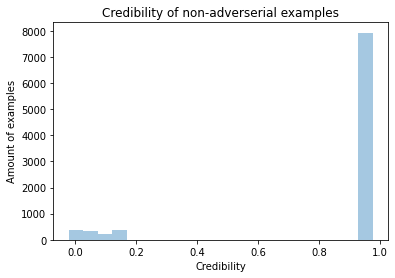

In [124]:
sns.distplot(counter_arr2, bins="doane",kde=False,hist_kws={"align" : "left"}).set_title("Credibility of non-adverserial examples")
plt.xlabel("Credibility")
plt.ylabel("Amount of examples")
plt.savefig('credibility_non_adv.png')
plt.show()